In [30]:
import pandas as pd

In [31]:
raw_path = "../data/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv"
df = pd.read_csv(raw_path)

In [32]:
print(df.shape)

(26208, 314)


In [33]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,215574.438255,...,510182.434440,510892.763641,512049.650147,512792.660486,513227.722201,513665.946230,513338.383882,512408.507833,510568.598127,508318.844450
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,148477.755194,...,695796.402981,702604.063025,709293.474456,714159.727665,716847.338283,717878.902186,720826.783733,724843.289367,729957.745787,734632.468660
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,106161.586055,...,288461.727101,288271.118755,287847.183593,287044.229109,286301.877814,285680.843518,285044.264672,284194.128893,283214.282228,282393.931681
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,324297.207309,...,964100.578626,966858.639801,969170.155864,970457.410038,970540.504388,969886.051550,970434.250479,970851.001272,974994.605890,981018.751871
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,105388.243306,...,282674.177502,282423.296576,281911.642124,281303.549642,280961.447460,280719.060835,280312.404076,279436.475212,278371.471330,277455.350725


In [42]:
id_vars = ['RegionID', 'RegionName', 'SizeRank', 'RegionType', 'StateName']
date_columns = df.columns.difference(id_vars)
#Melt to long format
df_melted = df.melt(id_vars, value_vars = date_columns,var_name='date', value_name='price')
#Convert to datetime
df_melted['date'] = pd.to_datetime(df_melted['date'], format='%Y-%m-%d', errors='coerce')
#drop rows with missing strings/values
df_melted.dropna(subset=['date', 'price'], inplace=True)
print(df_melted.head())

   RegionID  RegionName  SizeRank RegionType StateName       date  \
0     91982       77494         1        zip        TX 2000-01-31   
1     61148        8701         2        zip        NJ 2000-01-31   
2     91940       77449         3        zip        TX 2000-01-31   
3     62080       11368         4        zip        NY 2000-01-31   
4     91733       77084         5        zip        TX 2000-01-31   

           price  
0  215574.438255  
1  148477.755194  
2  106161.586055  
3  324297.207309  
4  105388.243306  


In [44]:
#Filter Colorado Zip by prefix (80000-81658)
df_melted['RegionName'] = df_melted['RegionName'].astype(str)

df_co = df_melted[df_melted['RegionName'].str.match(f'^80[0-9]{3}|^81[0-5][0-9]|^816[0-5]')]
print(df_co.head())

      RegionID RegionName  SizeRank RegionType StateName       date  \
231      93263      80134       237        zip        CO 2000-01-31   
516      93490      80634       527        zip        CO 2000-01-31   
526      93487      80631       538        zip        CO 2000-01-31   
934      93460      80538       950        zip        CO 2000-01-31   
1027     93309      80233      1043        zip        CO 2000-01-31   

              price  
231   240161.640851  
516   171951.702858  
526   121087.965586  
934   199004.412339  
1027  160278.521095  


In [45]:
import os
os.makedirs('../data', exist_ok=True)
df_co.to_csv('../data/colorado_home_values.csv', index=False)

In [55]:
import pandas as pd
df_co = pd.read_csv('../data/colorado_home_values.csv', parse_dates=["date"])

In [72]:
#Selecting one ZIP
df_co['RegionName'] = df_co['RegionName'].astype(str).str.strip()
target_zip ='80134'
df_zip = df_co[df_co['RegionName'] == target_zip].sort_values('date').copy()
df_zip.head()

,RegionID,RegionName,SizeRank,RegionType,StateName,date,price
0,93263,80134,237,zip,CO,2000-01-31,240161.640851
106,93263,80134,237,zip,CO,2000-02-29,240951.637827
212,93263,80134,237,zip,CO,2000-03-31,242102.328697
318,93263,80134,237,zip,CO,2000-04-30,244636.691328
424,93263,80134,237,zip,CO,2000-05-31,247699.141937


In [73]:
#Create Lag features
for lag in range(1,4):
    df_zip[f'value_lag_{lag}'] = df_zip['price'].shift(lag)
df_zip.dropna(inplace=True)

In [74]:
#Split into Train Test using last 12 months as test
train = df_zip[:-12]
test = df_zip[-12:]

feature_cols = [f'value_lag_{i}' for i in range(1,4)]
target_col = 'price'

X_train, y_train = train[feature_cols], train[target_col]
X_test, y_test = test[feature_cols], test[target_col]

In [77]:
#Train Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (Test): {mae:.2f}')

Mean Absolute Error (Test): 2875.03


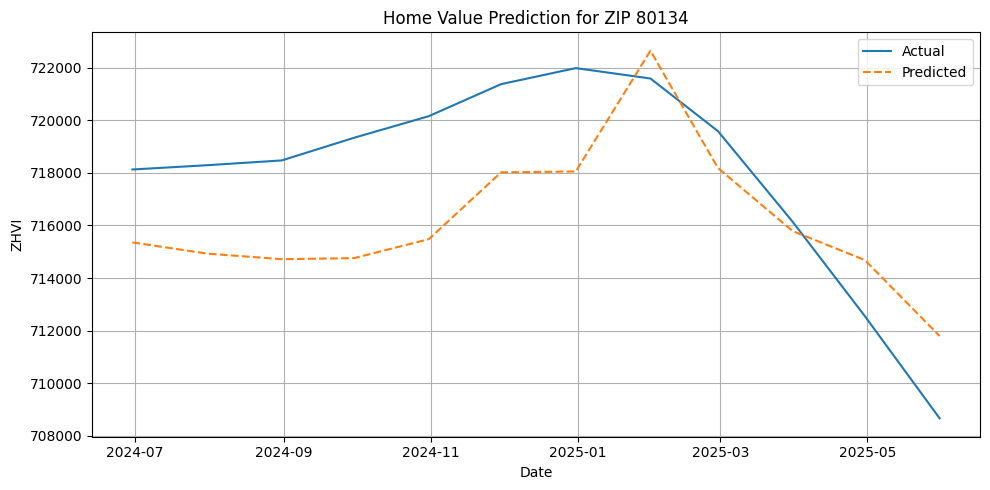

In [78]:
#Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(test['date'], y_test, label='Actual')
plt.plot(test['date'], y_pred, label='Predicted', linestyle='--')
plt.title(f'Home Value Prediction for ZIP {target_zip}')
plt.ylabel('ZHVI')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
#Trying XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

#Prepare target
feature_cols = [f'value_lag_{i}' for i in range(1,4)]
X_train = df_zip[:-12][feature_cols]
y_train = df_zip[:-12]['price']
X_test = df_zip[-12:][feature_cols]
y_test = df_zip[-12:]['price']

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

#prediction and evaluation
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'XGBoost MAE: ${mae:,.0f}')

XGBoost MAE: $3,756


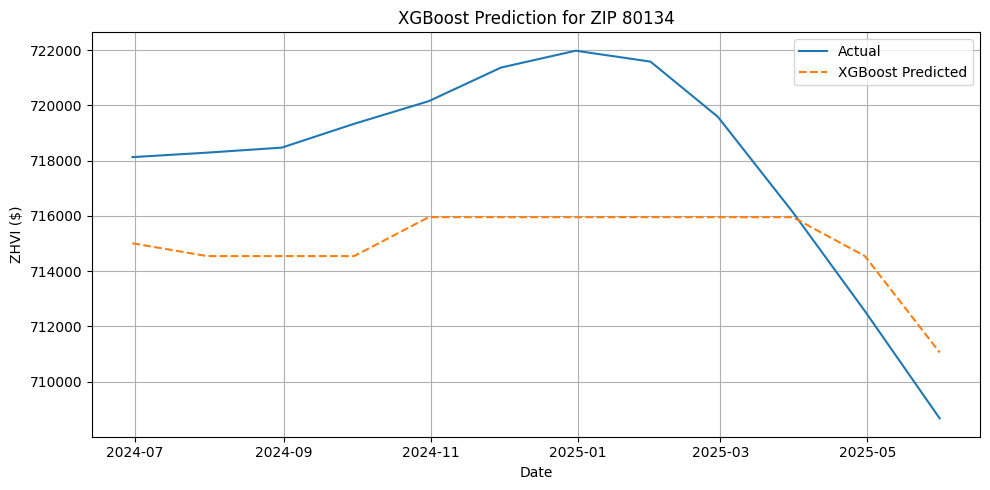

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(df_zip[-12:]["date"], y_test, label="Actual")
plt.plot(df_zip[-12:]["date"], y_pred, label="XGBoost Predicted", linestyle="--")
plt.title(f"XGBoost Prediction for ZIP {target_zip}")
plt.ylabel("ZHVI ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
#forward looking prediction...

#last known values to seed prediction
last_known = df_zip[['date', 'price']].copy().sort_values('date')
last_known = last_known.iloc[-3:] #last three months

#create future dates
future_months = 6
last_date = last_known['date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_months, freq='MS')

#store predictions
predictions = []

for date in future_dates:
    
    lags = last_known['price'].values[-3:]
    X_next = pd.DataFrame([{
        'value_lag_1': lags[-1], 
        'value_lag_2': lags[-2],
        'value_lag_3': lags[-3]
    }])
    
    y_next = model.predict(X_next)[0]
    predictions.append({'date': date, 'predicted_price': y_next})
    
    last_known = pd.concat([last_known, pd.DataFrame({'date': [date], 'price': [y_next]})], ignore_index=True)
    
df_forecast = pd.DataFrame(predictions)
print(df_forecast)

        date  predicted_price
0 2025-07-01    710392.749801
1 2025-08-01    711520.504354
2 2025-09-01    712640.846124
3 2025-10-01    713389.177937
4 2025-11-01    714060.445430
5 2025-12-01    712981.050926


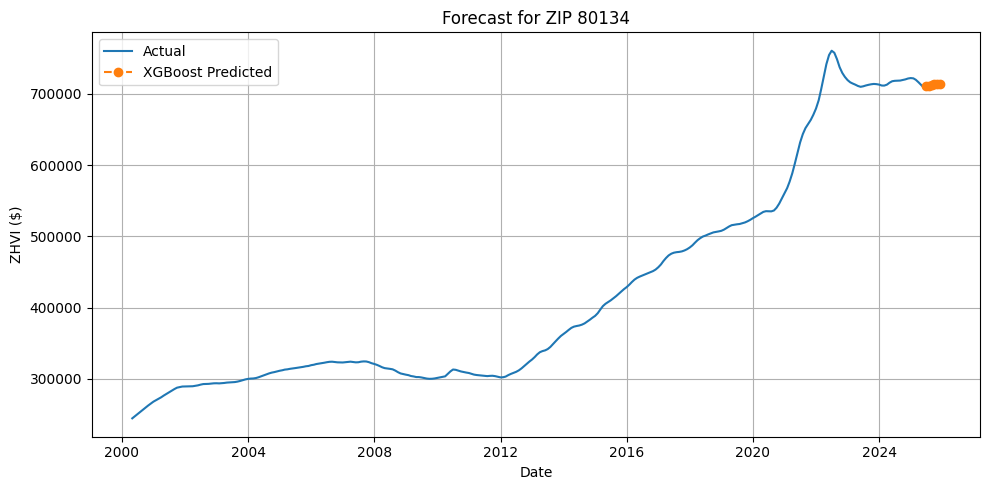

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(df_zip["date"], df_zip['price'], label="Actual")
plt.plot(df_forecast['date'], df_forecast['predicted_price'], label="Predicted", linestyle="--", marker='o')
plt.title(f"Forecast for ZIP {target_zip}")
plt.ylabel("ZHVI ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
#forward looking prediction...

#last known values to seed prediction
last_known = df_zip[['date', 'price']].copy().sort_values('date')
last_known = last_known.iloc[-3:] #last three months

#create future dates
future_months = 6
last_date = last_known['date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_months, freq='MS')

#store predictions
predictions = []

for date in future_dates:
    
    lags = last_known['price'].values[-3:]
    X_next = pd.DataFrame([{
        'value_lag_1': lags[-1], 
        'value_lag_2': lags[-2],
        'value_lag_3': lags[-3]
    }])
    
    y_next = xgb_model.predict(X_next)[0]
    predictions.append({'date': date, 'predicted_price': y_next})
    
    last_known = pd.concat([last_known, pd.DataFrame({'date': [date], 'price': [y_next]})], ignore_index=True)
    
df_forecast_xgb = pd.DataFrame(predictions)
print(df_forecast_xgb)

        date  predicted_price
0 2025-07-01      710236.1875
1 2025-08-01      713225.0000
2 2025-09-01      720139.2500
3 2025-10-01      716902.8750
4 2025-11-01      715009.1875
5 2025-12-01      712626.5000
